In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
torch.__version__

'1.13.1'

# 数据准备

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Normalize(0.5, 0.5)  
])

In [4]:
train_ds = torchvision.datasets.MNIST('data',           
                                      train=True,                      
                                      transform=transform,            
                                      download=True)                   

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)   

## 1：数据准备完毕

In [6]:
imgs, _ = next(iter(dataloader)) 

In [7]:
imgs.shape

torch.Size([64, 1, 28, 28])

# G

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(             
                                  nn.Linear(100, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 28*28),
                                  nn.Tanh()                     
        )
    def forward(self, x):             
        img = self.main(x)
        img = img.view(-1, 28, 28)  
        return img

# D

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
                                  nn.Linear(28*28, 512),
                                  nn.LeakyReLU(),   
                                  nn.Linear(512, 256),
                                  nn.LeakyReLU(),
                                  nn.Linear(256, 1),
                                  nn.Sigmoid()
        )
    def forward(self, x):  
        x = x.view(-1, 28*28)  
        x = self.main(x)
        return x

# 初始化模型、

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
gen = Generator().to(device)  
dis = Discriminator().to(device) 

In [46]:
d_optim = torch.optim.Adam(dis.parameters(), lr=0.0001)  
g_optim = torch.optim.Adam(gen.parameters(), lr=0.0001)  

In [47]:
loss_fn = torch.nn.BCELoss() 

# draw funtion

In [48]:
def gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())  
  
    fig = plt.figure(figsize=(4, 4))  
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((prediction[i] + 1)/2) 
        plt.axis('off') 
    plt.show()  

In [49]:
test_input = torch.randn(16, 100, device=device) 

# GAN Train

In [50]:
D_loss = []
G_loss = []

Epoch: 0


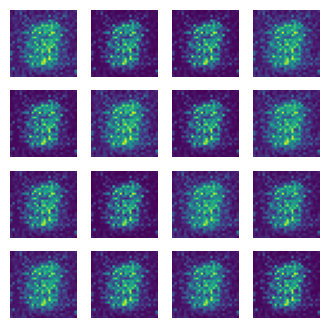

Epoch: 1


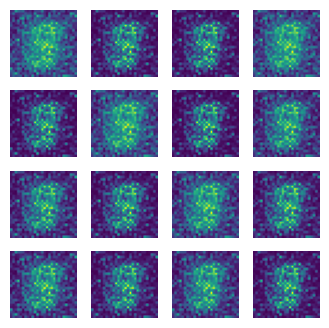

Epoch: 2


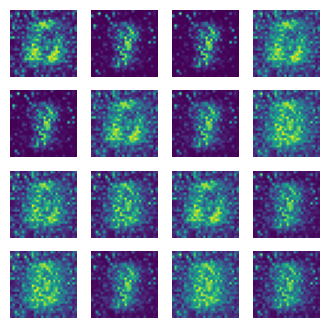

Epoch: 3


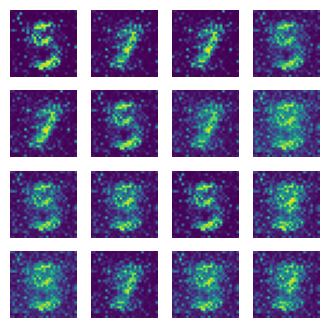

Epoch: 4


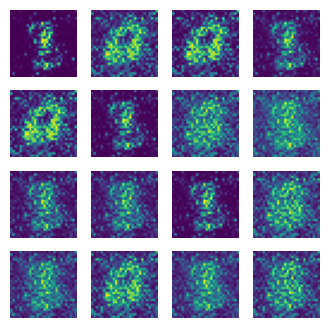

Epoch: 5


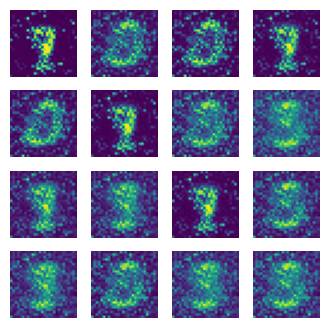

Epoch: 6


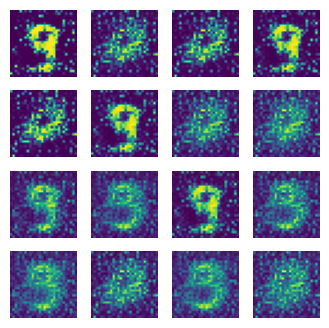

Epoch: 7


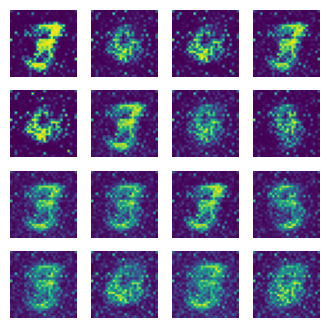

Epoch: 8


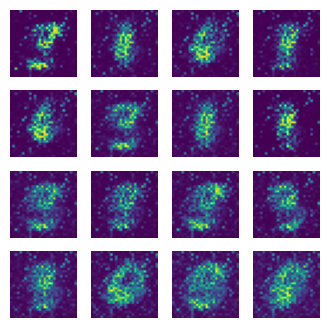

Epoch: 9


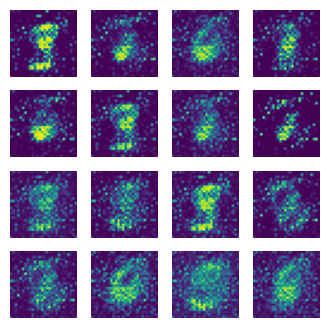

Epoch: 10


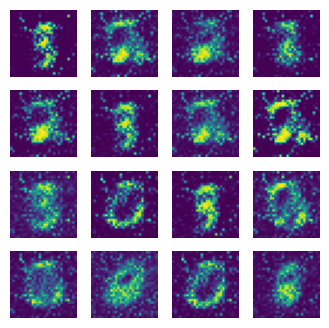

Epoch: 11


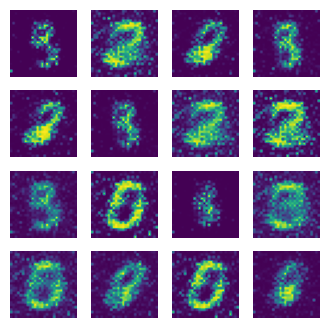

Epoch: 12


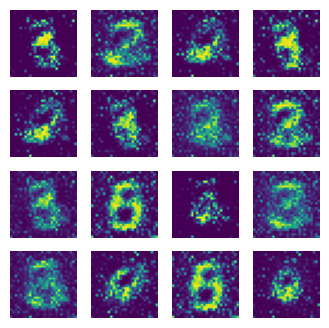

Epoch: 13


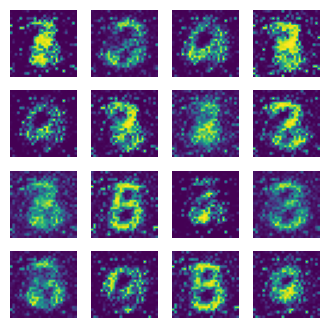

Epoch: 14


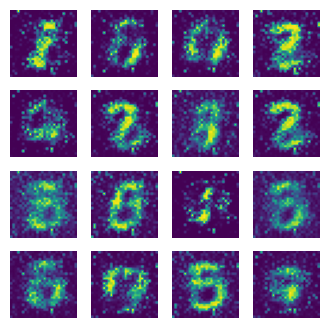

Epoch: 15


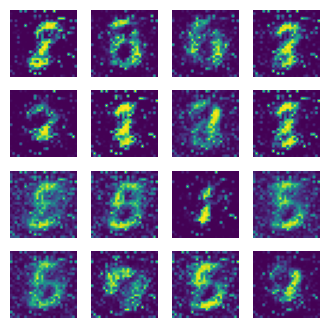

Epoch: 16


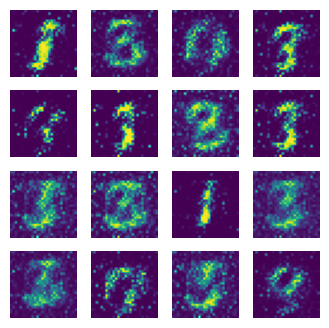

Epoch: 17


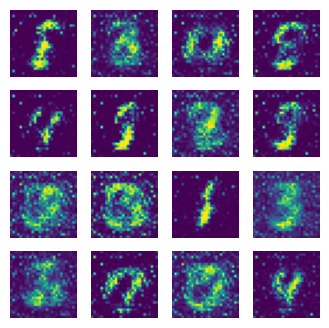

Epoch: 18


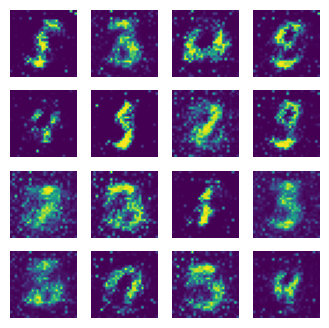

Epoch: 19


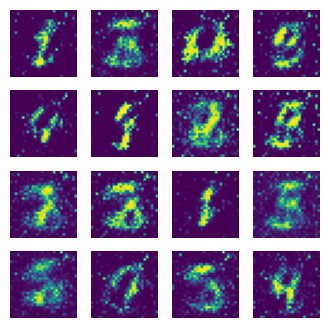

In [51]:

for epoch in range(20):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader) 
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0) 
        random_noise = torch.randn(size, 100, device=device) 
        
        d_optim.zero_grad() 
        
        real_output = dis(img)      
      
        d_real_loss = loss_fn(real_output, 
                              torch.ones_like(real_output))     
        d_real_loss.backward()   
        
        gen_img = gen(random_noise)
       
        fake_output = dis(gen_img.detach()) 
      
        d_fake_loss = loss_fn(fake_output, 
                              torch.zeros_like(fake_output))      
        d_fake_loss.backward()  
        
        d_loss = d_real_loss + d_fake_loss
        d_optim.step() 
        
        g_optim.zero_grad()
        fake_output = dis(gen_img)  
        g_loss = loss_fn(fake_output, 
                         torch.ones_like(fake_output))   
       
        g_loss.backward() 
        g_optim.step()  
        
        with torch.no_grad():  
            d_epoch_loss += d_loss  
            g_epoch_loss += g_loss
            
    with torch.no_grad():  
        d_epoch_loss /= count
        g_epoch_loss /= count 
        D_loss.append(d_epoch_loss.item())
        G_loss.append(g_epoch_loss.item())
        print('Epoch:', epoch)
        gen_img_plot(gen, test_input)

In [ ]:
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.legend()